## NLP - Twitter US Airline Sentiment Analysis: ## 

### **1.0 Problem Statement** ###

Sentiment analysis, as an automated process of identifying and classifying subjective information in text data, is widely applied to the voices of the customer materials. 

In this project, Sentiment Analysis model was developed to classify the customers' tweets for six major US airlines. In such a binary classification problem, AUC and Recall Score would be used as performance metrics in this case.

### **2.0 Packages** ###

In [272]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
from wordcloud import WordCloud 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.embeddings import Embedding

import tensorflow as tf 
import keras
from keras.layers import Dropout


from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:95%!important;width:auto!important;}</style>"))

### **3.0 Dataset** ###

Twitter US Airline Sentiment: 

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


#### 3.1 Load the Dataset ####

In [176]:
df = pd.read_csv('Tweets.csv')

#### 3.2 Check Data Dimensions ####

In [177]:
print('The shape of dataset is:', df.shape)

The shape of dataset is: (14640, 15)


#### 3.3 Check Data Types ####

In [178]:
# Check data types in dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

#### 3.4 Check Duplicated Data ####

In [179]:
# Check duplicated data
duplicatedfRow = df[df.duplicated(keep=False)]
duplicatedfRow.sort_values("tweet_id", inplace = True)
print('The shape of duplicated data is:', duplicatedfRow.shape)
print()
print(duplicatedfRow.head())

The shape of duplicated data is: (72, 15)

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
12001  570272018840428544           neutral                           1.0   
12162  570272018840428544           neutral                           1.0   
12159  570272880556011520          positive                           1.0   
11998  570272880556011520          positive                           1.0   
11997  570273710210469888          positive                           1.0   

      negativereason  negativereason_confidence   airline  \
12001            NaN                        NaN  American   
12162            NaN                        NaN  American   
12159            NaN                        NaN  American   
11998            NaN                        NaN  American   
11997            NaN                        NaN  American   

      airline_sentiment_gold             name negativereason_gold  \
12001                    NaN  pokecrastinator             

All above identified duplicates should be removed.

#### 3.4 Check Missing Data ####

In [180]:
print(df.isnull().sum())

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


Since 'airline_sentiment_gold', 'negativereason_gold' and 'tweet_coord' have more than 10000 null values, it would be meaningless to keep them in the dataset.

**Comment**: Based on all above information, the **most relevant features** were:

* tweet_id: ID of tweet

* airline_sentiment: The sentiment of tweet (positive or negative or neutral)

* negativereason: its a categorical feature showing reason of negative tweet

* airline: Name of airline. Categorical feature with six values

* text: contents of tweet


### **4.0 Data Pre-processing** ###

#### 4.1 Remove duplicated data ####

In [181]:
# Remove duplicates
df = df.drop_duplicates(keep='first')

# Verify
duplicatedfRow = df[df.duplicated(keep=False)]
print('The shape of duplicated data is:', duplicatedfRow.shape)

# Print the shape of new dataframe
print('The shape of dataset is:', df.shape)

The shape of duplicated data is: (0, 15)
The shape of dataset is: (14604, 15)


#### 4.2 Drop the unnecessary columns ####

In [182]:
# New Dataframe with selected features
twdf=df[['airline_sentiment','negativereason','airline','text']]
twdf.head()

,airline_sentiment,negativereason,airline,text
0,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...


### **5.0 Exploratory Data Analysis** ###

In [183]:
# Check the records for new dataset
print('The number of records where sentiment is negative and no reason is given:', twdf[twdf['airline_sentiment']=='negative'].loc[twdf['negativereason'].isnull()].shape[0])
print('The number of records where sentiment is positive or neutral and a reason is given:', twdf[twdf['airline_sentiment']!='negative'].loc[twdf['negativereason'].notnull()].shape[0])

The number of records where sentiment is negative and no reason is given: 0
The number of records where sentiment is positive or neutral and a reason is given: 0


#### 5.1 Pie Chart ####

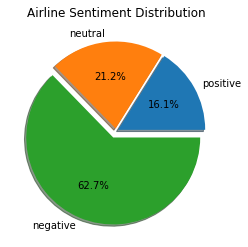

In [184]:
# Distribution of Airline Sentiments
ST = df.airline_sentiment.value_counts().sort_values()
plt.pie(ST, labels=ST.index,autopct='%1.1f%%', shadow=True, explode = [0.03, 0.03, 0.08] )
plt.title("Airline Sentiment Distribution")
plt.show()

**Comment**: 

* The majority of travellers had the negative sentiments

* There were more neutral sentiments than positive sentiments

* Such proportion of airline sentiments might because peolple feel the need to expressed themselves more when they have bad experience of airline than when they have good experience

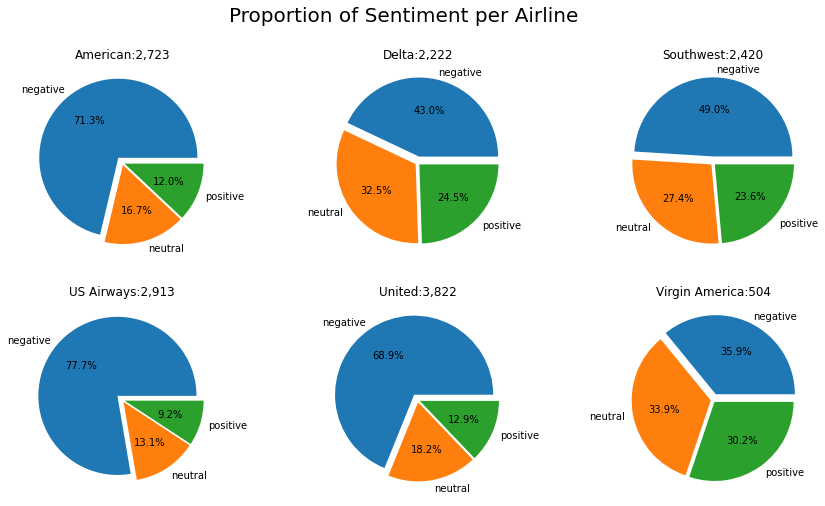

In [185]:
# Distribution of Sentiments per Airline

# Groupby
a = df.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()

# Pie charts per airline
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")
plt.suptitle("Proportion of Sentiment per Airline", fontsize = 20)    
plt.show()

**Comment**:

* American, US Airways: American airlines merged US Airways on 2015. Coincidentally or not, the sentiment for these two airlines shows negative in general.

* United: 68.9% of people felt it negative.

* Delta, Southwest: Better than American and US Airways as the proportion of negative sentiment is less than 50%.

* Virgin America: The proportion of sentiments is very well-balanced, but the count is not as many as the other's one.

#### 5.2 Count Plot ####

Text(0.5, 1.0, 'Total Counts of Tweets per Airline')

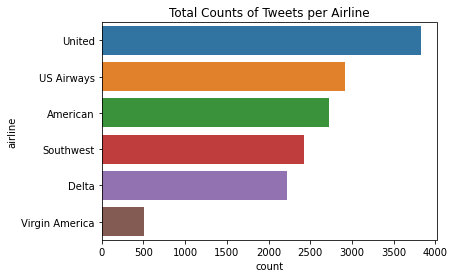

In [186]:
# Total Counts of Tweets per Airline
sns.countplot(data=twdf,y=twdf['airline'],order = twdf['airline'].value_counts().
              index).set_title('Total Counts of Tweets per Airline')

**Comment**:

* United Airline had the maximum number of tweets.

* Virgin America Airline had the minimum number of tweets.

Text(0.5, 1.0, 'Count per Nagetive Reasons')

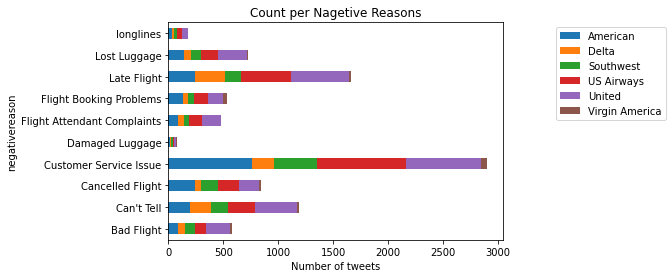

In [187]:
# Distribution of Number of negative tweets for every Airline
types = twdf.groupby("negativereason")['airline'].value_counts(normalize=False).sort_index()
types.unstack().plot(kind='barh', stacked='True')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.xlabel('Number of tweets')
plt.title('Count per Nagetive Reasons')

**Comment**:

* Significant number of people suffered from Customer Serive and late flight in various airline

* Least number of people suffered from damaged luggage and longliness

Text(0.5, 1.0, 'Percentage Wise Distribution of Negative Tweets for Each Airline')

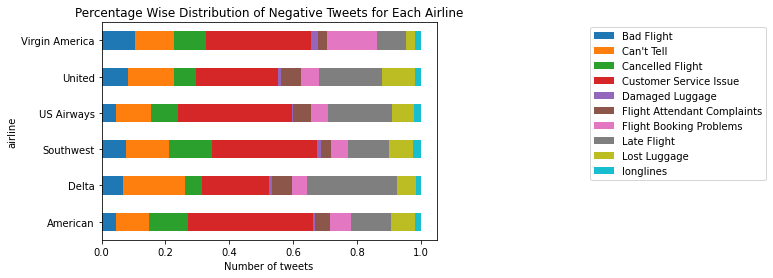

In [188]:
types = twdf.groupby("airline")['negativereason'].value_counts(normalize=True).unstack()
types.plot(kind='barh', stacked='True')
plt.legend(bbox_to_anchor=(2, 1), loc='upper right')
plt.xlabel('Number of tweets')
plt.title('Percentage Wise Distribution of Negative Tweets for Each Airline')

**Comment**:

* Delta and united airlines have better customer service than other airlines
* Virgin America need to pay attetion to the flight booking problems
* Delta passangers are suffering more from late flights than any other reason.
* The luggage would be more safe while traveling with Virgin America -- Here, we don't have any information about whether the lost luggage could be found while traveling.


### **6.0 Text Preprocessing** ###

*Procedure*: 

<ol type = "1">
  <li>Regular expression</li>
  <li>Decontractions</li>
  <li>Checking Stopwords</li>

In [189]:
# Check the descriptive statistics of text lengh
df.text.str.len().describe()

count    14604.000000
mean       103.828335
std         36.258528
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

**Comment**:
* Tweet text is consisted of 103 length in average.
* Minimum length is 12, and maximum one is 186.

Since text for each tweets shares the common rule starting with @ + airlines' name, the following step would be needed.

In [190]:
# Remove @ with Airline names
twdf['text']=twdf['text'].str.replace('@VirginAmerica','')
twdf['text']=twdf['text'].str.replace('@united','')
twdf['text']=twdf['text'].str.replace('@SouthwestAir','')
twdf['text']=twdf['text'].str.replace('@JetBlue','')
twdf['text']=twdf['text'].str.replace('@AmericanAir','')
twdf['text']=twdf['text'].str.replace('@USAirways','')
twdf.head()

,airline_sentiment,negativereason,airline,text
0,neutral,NaN,Virgin America,What @dhepburn said.
1,positive,NaN,Virgin America,plus you've added commercials to the experien...
2,neutral,NaN,Virgin America,I didn't today... Must mean I need to take an...
3,negative,Bad Flight,Virgin America,"it's really aggressive to blast obnoxious ""en..."
4,negative,Can't Tell,Virgin America,and it's a really big bad thing about it


In [191]:
# Decontractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
# Reference: https://stackoverflow.com/a/47091490/4084039

In [192]:
# Stopwords

# Remove the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
# Reference: https://gist.github.com/sebleier/554280

In [193]:
# Combine all the above functions to preprocess text
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('http"', ' ')          # added later
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

# Create a new column for clean text
twdf['text_clean']=preprocess_text(twdf['text'].values)

# Drop the original column of text
twdf=twdf.drop(['text'],axis=1)
twdf.head()

100%|██████████| 14604/14604 [00:02<00:00, 6469.11it/s]


,airline_sentiment,negativereason,airline,text_clean
0,neutral,NaN,Virgin America,dhepburn said
1,positive,NaN,Virgin America,plus added commercials experience tacky
2,neutral,NaN,Virgin America,not today must mean need take another trip
3,negative,Bad Flight,Virgin America,really aggressive blast obnoxious entertainmen...
4,negative,Can't Tell,Virgin America,really big bad thing


In [194]:
# Merge neutral and positive sentiments into one category, making it binary classfication problem
twdf['airline_sentiment']=twdf['airline_sentiment'].str.replace('neutral','positive')

# Convert class label into numerical number, where 1 represents negative tweets so that it could be reflected in recall score
twdf['airline_sentiment'].replace(to_replace='positive', value=0, inplace=True)
twdf['airline_sentiment'].replace(to_replace='negative', value=1, inplace=True)

# Save cleaned dataset as csv file
twdf.to_csv("tweets_preprocessed.csv")

# Print first five rows
twdf.head()

,airline_sentiment,negativereason,airline,text_clean
0,0,NaN,Virgin America,dhepburn said
1,0,NaN,Virgin America,plus added commercials experience tacky
2,0,NaN,Virgin America,not today must mean need take another trip
3,1,Bad Flight,Virgin America,really aggressive blast obnoxious entertainmen...
4,1,Can't Tell,Virgin America,really big bad thing


#### 6.1 Analysis of Frequency of Words ####

In [201]:
# Count frequency of words
freq=twdf['text_clean'].str.split(expand=True).stack().value_counts().to_frame()
freq.rename(columns = {0:'count'}, inplace = True)
print(freq.head())
print('Thus, the most frequently used word in tweets was', freq.index[0], '.')

        count
flight   3930
not      3654
no       1502
get      1340
co       1211
Thus, the most frequently used word in tweets was flight .


Text(0.5, 1.0, 'Frequency v.s. Number of Words')

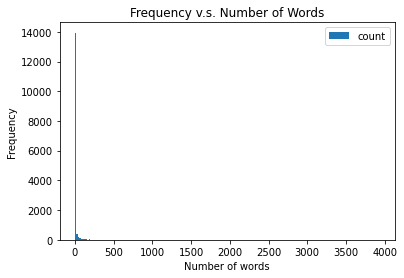

In [211]:
# Histogram: Frequency of Words
freq.plot.hist(bins=200)
plt.xlabel("Number of words")
plt.title("Frequency v.s. Number of Words")

**Comment:**
The above plot showed that the data had right-skewed distribution, indicating the data was highly imbalanced with very large number of words appeared only few times.

In [205]:
print("Total number of words in Corpus:",freq['count'].sum())
print()
print("Total number of words appeared more than 3000 times in Corpus:",freq.loc[freq['count']>3000].shape[0])
print("Total number of words appeared less than 3000 times and more than 2000 times in Corpus:",freq.loc[freq['count']<=3000].loc[freq['count']>2000].shape[0])
print("Total number of words appeared less than 2000 times and more than 2000 times in Corpus:",freq.loc[freq['count']<=2000].loc[freq['count']>1000].shape[0])
print("Total number of words appeared less than 1000 times and more than 500 times in Corpus:",freq.loc[freq['count']<=1000].loc[freq['count']>500].shape[0])
print("Total number of words appeared less than 500 times and more than 100 times in Corpus:",freq.loc[freq['count']<=500].loc[freq['count']>100].shape[0])
print("Total number of words appeared less than 100 times and more than 50 times in Corpus:",freq.loc[freq['count']<=100].loc[freq['count']>50].shape[0])
print("Total number of words appeared less than 50 times and more than 25 times in Corpus:",freq.loc[freq['count']<=50].loc[freq['count']>25].shape[0])
print("Total number of words that has appeared less than 25 times and more than 10 times in Corpus:",freq.loc[freq['count']<=25].loc[freq['count']>10].shape[0])
print("Total number of words that has appeared less than 10 times and more than 5 times in Corpus:",freq.loc[freq['count']<=10].loc[freq['count']>5].shape[0])
print("Total number of words that has appeared less than 5 times and more than 3 times in Corpus:",freq.loc[freq['count']<=5].loc[freq['count']>3].shape[0])
print("Total number of words that has appeared 3 times in Corpus:",freq.loc[freq['count']==3].shape[0])
print("Total number of words that has appeared 2 times in Corpus:",freq.loc[freq['count']==2].shape[0])
print("Total number of words that has appeared 1 times in Corpus:",freq.loc[freq['count']==1].shape[0])

Total number of words in Corpus: 144190

Total number of words appeared more than 3000 times in Corpus: 2
Total number of words appeared less than 3000 times and more than 2000 times in Corpus: 0
Total number of words appeared less than 2000 times and more than 2000 times in Corpus: 6
Total number of words appeared less than 1000 times and more than 500 times in Corpus: 22
Total number of words appeared less than 500 times and more than 100 times in Corpus: 219
Total number of words appeared less than 100 times and more than 50 times in Corpus: 252
Total number of words appeared less than 50 times and more than 25 times in Corpus: 368
Total number of words that has appeared less than 25 times and more than 10 times in Corpus: 823
Total number of words that has appeared less than 10 times and more than 5 times in Corpus: 907
Total number of words that has appeared less than 5 times and more than 3 times in Corpus: 956
Total number of words that has appeared 3 times in Corpus: 894
Total 

**Comment:**
* 'flight' and 'not' were two words that are used for more than 3000 times.
* There were 8643 words apppeared only once, which was not good for modeling.

Let's take a look at the words that only appeared once.

In [217]:
freq.tail(20)

,count
quietly,1
whagpknnlf,1
dani,1
danihampton,1
s4,1
deed,1
0pdntgbxc6,1
essentials,1
hotlanta,1
x5zqssjtrb,1


**Comment**: There were some misspelled words and cat-typing entries could be observed in the above list.

#### 6.2 WordClouds ####

In [219]:
# Count words
text = " ".join(review for review in twdf['text_clean'])
print ("There are {} words in the combinations of all review.".format(len(text)))

There are 923453 words in the combinations of all review.


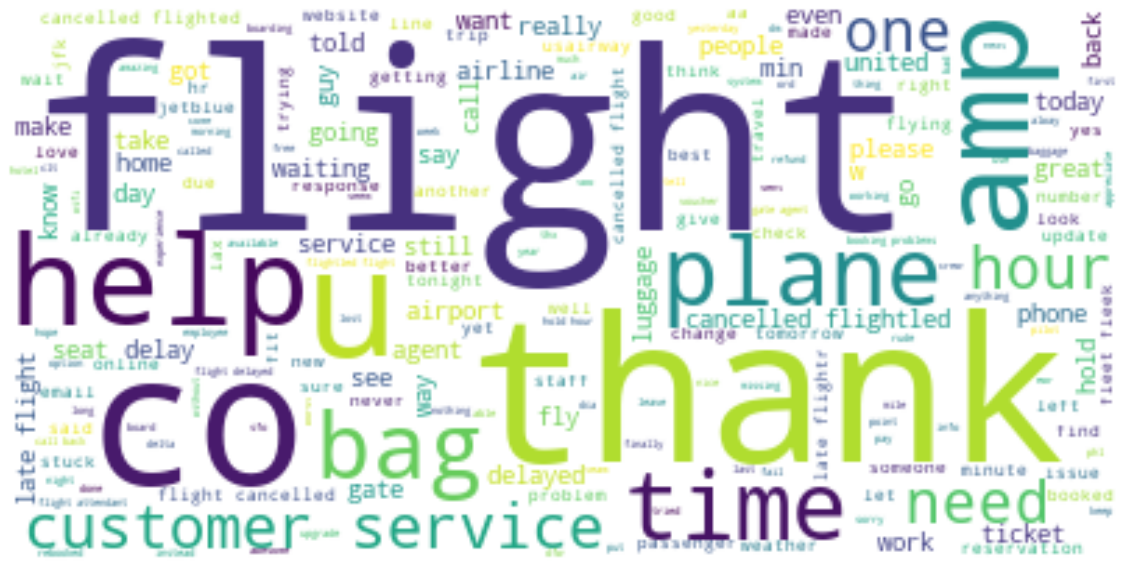

In [221]:
# Wordcloud for the entire corpus
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

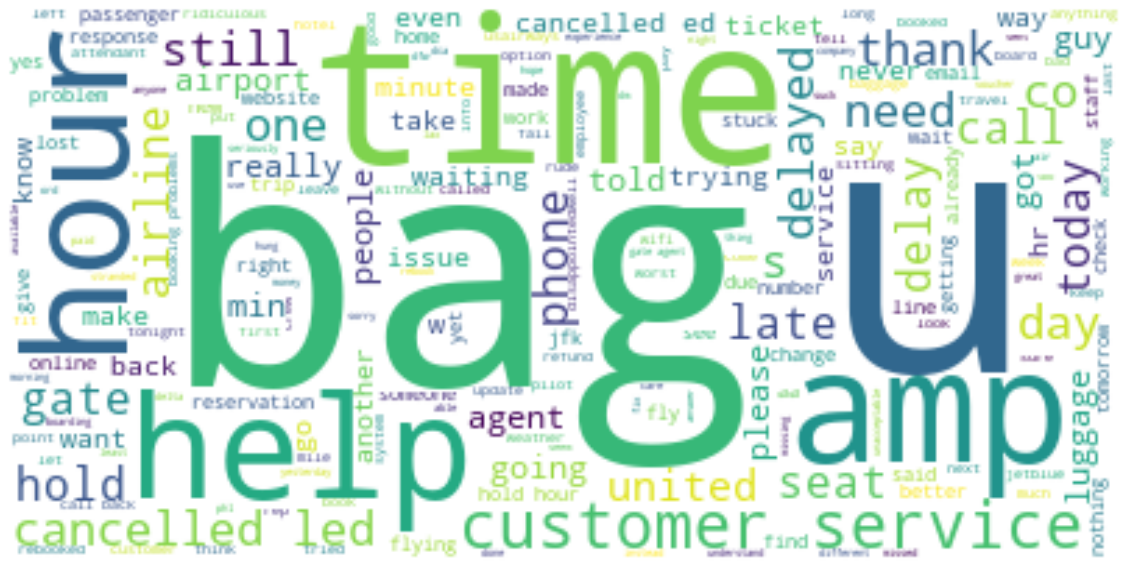

In [222]:
# Wordcloud for negative sentiments
textNeg = " ".join(review for review in twdf['text_clean'].loc[twdf['airline_sentiment']==1])
textNeg=textNeg.replace('flight', '')
textNeg=textNeg.replace('plane', '')
wordcloud = WordCloud(background_color="white").generate(textNeg)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Comment**: People were complaining about customer service, delayed/cancelled flights, and lost/damaged baggage.

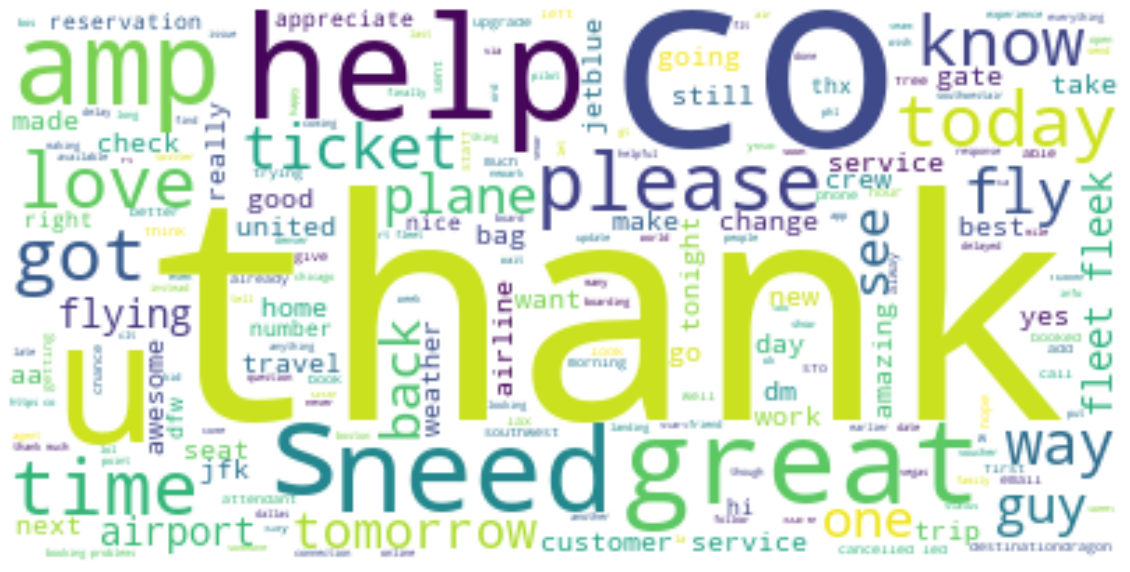

In [223]:
# Wordcloud for positive sentiments
textPos = " ".join(review for review in twdf['text_clean'].loc[twdf['airline_sentiment']==0])
textPos=textPos.replace('flight', '')
wordcloud = WordCloud(background_color="white").generate(textPos)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Comment**: People tend to say 'thank u', 'great', 'love', etc. when they are satisfied with their trip with airlines.

### 7.0 Machine Learning Approach ###

#### 7.1 Naive Bayes with BOW, TFIDF, Word2Vec for Twitter US Airline Sentiment Analysis ####

ML approach uses ML algorithm to classify the text data.

To make the algorithms understand the text as a feature, converting the text to the vector or other numeric format is crucial.

* Vectorization : CountVectorizer, TfidfTransformer, Word2Vec
* Model: Naive Bayes

In [232]:
# Split the dataset
X = twdf[['text_clean']]
y = twdf['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

*7.1.1 Naive Bayes with Bag of words*

In [234]:
# Getting BOW 
print("Before vectorizations:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print()

vectorizer = CountVectorizer(min_df=2,ngram_range=(1,4))
vectorizer.fit(X_train['text_clean'])
X_train_bow = vectorizer.transform(X_train['text_clean'].values)
X_test_bow = vectorizer.transform(X_test['text_clean'].values)

print("After vectorizations:")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)


Before vectorizations:
(10222, 1) (10222,)
(4382, 1) (4382,)

After vectorizations:
(10222, 16800) (10222,)
(4382, 16800) (4382,)


In [235]:
# Save X data as array
X_train_bow=X_train_bow.toarray()
X_test_bow=X_test_bow.toarray()

In [236]:
# Create the model
gnb = GaussianNB()
gnb.fit(X_train_bow, y_train)

# Predictions
pred = gnb.predict(X_test_bow)

# Model performance metrics
accNB = accuracy_score(y_test, pred)
y_pred_prob = gnb.predict_proba(X_test_bow)
aucScoreBOW = roc_auc_score(y_test,  y_pred_prob[:,1])
fprBOW, tprBOW, thresholds = roc_curve(y_test, y_pred_prob[:,1] )

print("Confusion matrix")
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(X_train_bow)
print("Train Recall score for NB is ",recall_score(y_train, predT))
print("Test Recall score for NB is ",recall_score(y_test, pred))

Confusion matrix
[[1218  416]
 [ 687 2061]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1634
           1       0.83      0.75      0.79      2748

    accuracy                           0.75      4382
   macro avg       0.74      0.75      0.74      4382
weighted avg       0.76      0.75      0.75      4382

AUC score for NB is  0.7477050183598533
Train Recall score for NB is  0.8964280143503354
Test Recall score for NB is  0.75


**Comment**:

* Test score of 0.7527 is fairly good.

* Test score is lower than the training score, indicating the possibility of overfitting.

*7.1.2 Naive Bayes with TFIDF*

In [237]:
# Vectorization
vectorizer = TfidfVectorizer(min_df=2,ngram_range=(1,4))
vectorizer.fit(X_train['text_clean'])
X_train_tfidf = vectorizer.transform(X_train['text_clean'].values)
X_test_tfidf = vectorizer.transform(X_test['text_clean'].values)

# Save as array
X_train_tfidf=X_train_tfidf.toarray()
X_test_tfidf=X_test_tfidf.toarray()

In [238]:
# Create the model
gnb = GaussianNB()
gnb.fit(X_train_tfidf, y_train)

# Predictions
pred = gnb.predict(X_test_tfidf)

# Performance metrics
accNB = accuracy_score(y_test, pred)
y_pred_prob = gnb.predict_proba(X_test_tfidf)
aucScoreTFIDF = roc_auc_score(y_test,  y_pred_prob[:,1])
fprTFIDF, tprTFIDF, thresholds = roc_curve(y_test, y_pred_prob[:,1] )
print("Confusion matrix")
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print("AUC score for NB is ",aucScoreTFIDF)
predT=gnb.predict(X_train_tfidf)
print("Train Recall score for NB is ",recall_score(y_train, predT))
print("Test Recall score for NB is ",recall_score(y_test, pred))

Confusion matrix
[[1201  433]
 [ 678 2070]]
              precision    recall  f1-score   support

           0       0.64      0.74      0.68      1634
           1       0.83      0.75      0.79      2748

    accuracy                           0.75      4382
   macro avg       0.73      0.74      0.74      4382
weighted avg       0.76      0.75      0.75      4382

AUC score for NB is  0.7442743492986554
Train Recall score for NB is  0.8965839962564343
Test Recall score for NB is  0.7532751091703057


**Comment**: The result is similar to the 7.1.1.

*7.1.3 Naive Bayes with Word2Vec*

In [239]:
# Vectorization
i=0
list_of_sentance=[]
for sentance in twdf['text_clean']:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=1,size=300, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# Compute average word2vec for each tweet
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each tweet/sentence
    sent_vec = np.zeros(300)
    cnt_words =0; # num of words with a valid vector in the sentence/tweet
    for word in sent: # for each word in a tweet/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 14604/14604 [00:13<00:00, 1058.85it/s]

14604
300


In [240]:
# Define X and y
X = np.array(sent_vectors)
y = twdf['airline_sentiment'].values
print("x shape:",X.shape,"y shape:",y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)


x shape: (14604, 300) y shape: (14604,)


In [241]:
# Create the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions
pred = gnb.predict(X_test)

# Performance metrics
accNB = accuracy_score(y_test, pred)
y_pred_prob = gnb.predict_proba(X_test)
aucScoreWORD2VEC = roc_auc_score(y_test,  y_pred_prob[:,1])
fprWORD2VEC, tprWORD2VEC, thresholds = roc_curve(y_test, y_pred_prob[:,1] )
print("Confusion matrix")
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print("AUC score for NB is ",aucScoreWORD2VEC)
predT=gnb.predict(X_train)
print("Train Recall score for NB is ",recall_score(y_train, predT))
print("Test Recall score for NB is ",recall_score(y_test, pred))

Confusion matrix
[[ 708  926]
 [ 531 2217]]
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1634
           1       0.71      0.81      0.75      2748

    accuracy                           0.67      4382
   macro avg       0.64      0.62      0.62      4382
weighted avg       0.66      0.67      0.66      4382

AUC score for NB is  0.6530281731545273
Train Recall score for NB is  0.8090781469349555
Test Recall score for NB is  0.8067685589519651



**Comment**: 

* The test score of 0.81 in NB with Word2Vec model is better than NB with BOW and TFIDF.
* The training score is close to the test score, indicating that the model is not overfitting.
* However, AUC of 0.65 is not as good as previous models.

*7.1.3 Result Comparison: ROC Curve*

In [243]:
# Create result table for the above three models
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
result_table=result_table.append({'classifiers':"Naive Bayer with BOW",'fpr':fprBOW,'tpr':tprBOW,'auc':aucScoreBOW}, ignore_index=True)
result_table=result_table.append({'classifiers':"Naive Bayer with TFIDF",'fpr':fprTFIDF,'tpr':tprTFIDF,'auc':aucScoreTFIDF}, ignore_index=True)
result_table=result_table.append({'classifiers':"Naive Bayer with W2V",'fpr':fprWORD2VEC,'tpr':tprWORD2VEC,'auc':aucScoreWORD2VEC}, ignore_index=True)
result_table.set_index('classifiers', inplace=True)
result_table

,fpr,tpr,auc
classifiers,,,
Naive Bayer with BOW,"[0.0, 0.25458996328029376, 1.0]","[0.0, 0.75, 1.0]",0.747705
Naive Bayer with TFIDF,"[0.0, 0.26499388004895963, 0.26499388004895963...","[0.0, 0.7532751091703057, 0.7536390101892285, ...",0.744274
Naive Bayer with W2V,"[0.0, 0.44002447980416154, 0.44063647490820074...","[0.0, 0.7081513828238719, 0.7081513828238719, ...",0.653028


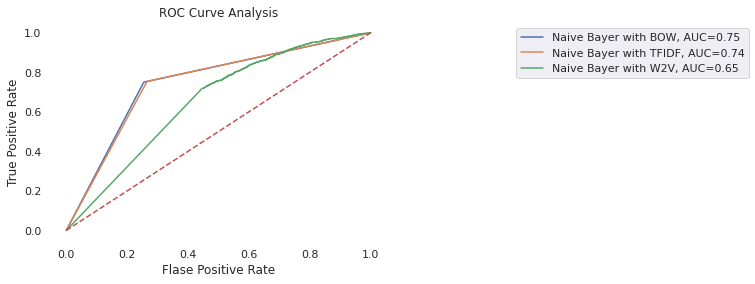

In [257]:
# Drawing multiple ROC Curves in a single plot
sns.set()
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, result_table.loc[i]['auc']))
ax = plt.gca()
ax.set_facecolor('xkcd:white')
ax.grid(False)

plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Flase Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve Analysis')
plt.legend(bbox_to_anchor=(2.1, 1), loc='upper right')
plt.show()

**Summary of Classification Report in previous models**:

* Precision: determines how many objects selected were correct
* Recall: tells you how many of the objects that should have been selected were actually selected
* F1 score: measures the weights of recall and precision (1 means precision and recall are equally important, 0 otherwise)
* Support: the number of occurrences of each class

**Comment**: 

Naive Bayes with BOW, TFIDF, Word2Vec showed the similar trend in their classification reports while the values was slightly different.

The values in classification reports confirms our previous data exploration analysis, where the data are very skewed to the negative reviews as shown by the lower support counts of the postive reviews. Also, positive reviews has large standard deviation with small frequencies, which we would not consider significant as shown by the lower precision, recall and F1 scores in the classification report.

However, despite that positive results are relatively not strong predictors in this dataset, it still shows a good accuracy in predicting the sentiment analysis. Therefore, we are comfortable here with the skewed dataset. 




#### 7.2 Word Embedding Layer in Keras ####

In [258]:
# list of sentences for further processsing
corpus = twdf['text_clean'].tolist()
corpus[:5]

['dhepburn said',
 'plus added commercials experience tacky',
 'not today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing']

In [263]:
# Remove less frequency words
all_ = [x for y in corpus for x in y.split(' ') ]
a,b = np.unique(all_, return_counts = True)
to_remove = a[b<3]
corpus = [' '.join(np.array(y.split(' '))[~np.isin(y.split(' '), to_remove)]) for y in corpus]

# Count the number of unique words
print("Number of unique words in corpus:",len(a))

# Length of longest sentence in corpus after removing less frequent words
max_length = len(max(corpus, key = len).split(" "))
print("Maximum length in corpus after removing less frequent words:", max_length)

Number of unique words in corpus: 4450
Maximum length in corpus after removing less frequent words: 20


In [268]:
# Encoding corpus
input_len = len(a)*5
corp_enc = [one_hot(d, input_len) for d in corpus]
print(corp_enc[:5])
print()

# Pad documents to a max length of 4 words
corp_pad = pad_sequences(corp_enc, maxlen=max_length, padding='post')
print(corp_pad)

[[17689], [11579, 9510, 12292, 16364], [9109, 11551, 9748, 2996, 18453, 1323, 22129, 18189], [8406, 12847, 2269, 868, 18703, 13043, 15518, 6855], [8406, 8607, 3072, 8302]]

[[17689     0     0 ...     0     0     0]
 [11579  9510 12292 ...     0     0     0]
 [ 9109 11551  9748 ...     0     0     0]
 ...
 [  139 18135 15341 ...     0     0     0]
 [ 2476  7233  1776 ...     0     0     0]
 [ 5374   563 18453 ...     0     0     0]]


**Notes**:

* one_hot converts each word into integer encoding (sequences)

* pad_sequences pads the sequences with zeros

In [269]:
# Set y
target = twdf['airline_sentiment'].values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(corp_pad, target, test_size=0.33, random_state=42, stratify=target)

In [273]:
# Define the model
vector_size = 200
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = Sequential()
model.add(Embedding(input_len, vector_size, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           4450000   
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 1)                 4001      
                                                                 
Total params: 4,454,001
Trainable params: 4,454,001
Non-trainable params: 0
_________________________________________________________________
None


In [274]:
# Fit the model
result=model.fit(X_train, y_train,validation_split=0.33, epochs=6,verbose=0,batch_size=64)

Recall: 0.8564339876174927


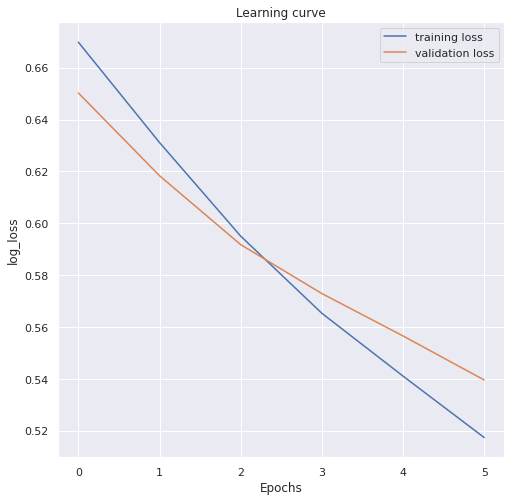

In [276]:
# Evaluate the model
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('Recall:',recall)

# Plot learning curve
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Comment**: Amongst the above models, embedding layer in Keras obtained the best recall score of 0.856.


**Conclusion**: Despite the imbalanced dataset, we were still able to build a fairly good Sentiment Analysis machine learning system to determine if the tweets are positive or negative. To further increase the model performance, we could gather more data to balance out the positive sentiments. Also, we could fine-tuning the algorithm to avoid bias sentiments.